# Data Project from Uber - Solution

## Data Exploration 

Read the dataset and observe the columns as in the overview.


In [1]:

import pandas as pd
import numpy as np

# read dataset
df = pd.read_csv("https://full-stack-assets.s3.eu-west-3.amazonaws.com/uber-challenge-00.csv")
df.head(10)

,Date,Time (Local),Eyeballs,Zeroes,Completed Trips,Requests,Unique Drivers
0,10-Sep-12,7,5,0,2,2,9
1,NaN,8,6,0,2,2,14
2,NaN,9,8,3,0,0,14
3,NaN,10,9,2,0,1,14
4,NaN,11,11,1,4,4,11
5,NaN,12,12,0,2,2,11
6,NaN,13,9,1,0,0,9
7,NaN,14,12,1,0,0,9
8,NaN,15,11,2,1,2,7
9,NaN,16,11,2,3,4,6


In [2]:

df.columns

Index(['Date', 'Time (Local)', 'Eyeballs ', 'Zeroes ', 'Completed Trips ',
       'Requests ', 'Unique Drivers'],
      dtype='object')

## Question 1 

**Which date had the most completed trips during the two week period?**


In [3]:

# forward fill empty Dates
df = df.fillna(method="ffill")
df

/var/folders/59/2pcxbs9j3w12ttcm1p2shjs40000gn/T/ipykernel_56494/630101955.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="ffill")


,Date,Time (Local),Eyeballs,Zeroes,Completed Trips,Requests,Unique Drivers
0,10-Sep-12,7,5,0,2,2,9
1,10-Sep-12,8,6,0,2,2,14
2,10-Sep-12,9,8,3,0,0,14
3,10-Sep-12,10,9,2,0,1,14
4,10-Sep-12,11,11,1,4,4,11
...,...,...,...,...,...,...,...
331,24-Sep-12,2,3,3,0,2,0
332,24-Sep-12,3,3,3,0,1,0
333,24-Sep-12,4,1,1,0,0,0
334,24-Sep-12,5,4,2,1,1,3


In [4]:

# aggregate on Date since the question asks the completed trips by Date
df_agg_date = df.groupby('Date').sum().reset_index()
df_agg_date.nlargest(1, 'Completed Trips ')

,Date,Time (Local),Eyeballs,Zeroes,Completed Trips,Requests,Unique Drivers
12,22-Sep-12,276,960,219,248,344,292


In [5]:

df_agg_date.nlargest(1, 'Completed Trips ')['Date']

12    22-Sep-12
Name: Date, dtype: object

## Question 2 

**What was the highest number of completed trips within a 24 hour
period?**


In [6]:
# to be able to use resample function, create timestamp and use as index
def create_timestamp(date, time):
    return pd.to_datetime(f"{date} {time}:00")
df['Timestamp'] = df.apply(lambda row: create_timestamp(row['Date'], row['Time (Local)']), axis=1)

# calculate rollings sums with 24 hours period
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=24)

# Only select numeric columns for rolling operations
numeric_cols = df.select_dtypes(include='number').columns

# Perform the rolling sum only on numeric columns
df_agg_twentyfour_hrs = (
    df.set_index("Timestamp")[numeric_cols]
      .rolling(window=indexer, min_periods=1)
      .sum()
)

df_agg_twentyfour_hrs.nlargest(1, 'Completed Trips ')


,Time (Local),Eyeballs,Zeroes,Completed Trips,Requests,Unique Drivers
Timestamp,,,,,,
2012-09-21 17:00:00,276.0,1015.0,207.0,278.0,367.0,349.0


In [7]:

# parse time interval to output
time_format = "%Y/%m/%d %H:%M"
df_agg_twentyfour_hrs['Time Interval']  = df_agg_twentyfour_hrs.index.strftime(time_format) +  "-" + (df_agg_twentyfour_hrs.index + pd.Timedelta('24 hours')).strftime(time_format)
df_agg_twentyfour_hrs

,Time (Local),Eyeballs,Zeroes,Completed Trips,Requests,Unique Drivers,Time Interval
Timestamp,,,,,,,
2012-09-10 07:00:00,276.0,212.0,38.0,29.0,39.0,150.0,2012/09/10 07:00-2012/09/11 07:00
2012-09-10 08:00:00,276.0,217.0,38.0,29.0,39.0,146.0,2012/09/10 08:00-2012/09/11 08:00
2012-09-10 09:00:00,276.0,222.0,40.0,27.0,37.0,138.0,2012/09/10 09:00-2012/09/11 09:00
2012-09-10 10:00:00,276.0,229.0,39.0,27.0,37.0,130.0,2012/09/10 10:00-2012/09/11 10:00
2012-09-10 11:00:00,276.0,232.0,38.0,28.0,37.0,124.0,2012/09/10 11:00-2012/09/11 11:00
...,...,...,...,...,...,...,...
2012-09-24 02:00:00,20.0,20.0,10.0,3.0,6.0,10.0,2012/09/24 02:00-2012/09/25 02:00
2012-09-24 03:00:00,18.0,17.0,7.0,3.0,4.0,10.0,2012/09/24 03:00-2012/09/25 03:00
2012-09-24 04:00:00,15.0,14.0,4.0,3.0,3.0,10.0,2012/09/24 04:00-2012/09/25 04:00


In [8]:

completed_trips = df_agg_twentyfour_hrs.nlargest(1, 'Completed Trips ')['Completed Trips '].values[0]
time_interval = df_agg_twentyfour_hrs.nlargest(1, 'Completed Trips ')['Time Interval'].values[0]
print("Number of completed trips:", completed_trips)
print("Time Interval:", time_interval)

Number of completed trips: 278.0
Time Interval: 2012/09/21 17:00-2012/09/22 17:00


## Question 3 

**Which hour of the day had the most requests during the two week
period?**


In [9]:
# aggregate on hour
df_agg_time = (
    df.groupby('Time (Local)')
      .sum(numeric_only=True)     # ✅ only sum numeric columns
      .reset_index()
)

df_agg_time.nlargest(1, 'Requests ')

,Time (Local),Eyeballs,Zeroes,Completed Trips,Requests,Unique Drivers
23,23,488,193,126,184,119


In [10]:

df_agg_time.nlargest(1, 'Requests ')['Time (Local)']

23    23
Name: Time (Local), dtype: int64

## Question 4 

**What percentages of all zeroes during the two week period occurred on
weekend (Friday at 5 pm to Sunday at 3 am)?**

**Tip**: The local time value is the start of the hour (e.g. `15` is the
hour from 3:00pm - 4:00pm)


In [11]:

# all zeroes in the dataset
total_zeroes = df['Zeroes '].sum()
total_zeroes

np.int64(1429)

In [12]:

# all zeroes in weekend based on given condition
df['Day'] = pd.to_datetime(df['Date']).dt.dayofweek
weekend_zeroes = df[((df['Day'] == 4) & (df['Time (Local)'] >= 17)) 
                          | (df['Day'] == 5) |
                          ((df['Day'] == 6) & (df['Time (Local)'] < 3))]['Zeroes '].sum()
weekend_zeroes

/var/folders/59/2pcxbs9j3w12ttcm1p2shjs40000gn/T/ipykernel_56494/1813053006.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Day'] = pd.to_datetime(df['Date']).dt.dayofweek


np.int64(641)

In [13]:

# calculate the percentage
weekend_zeroes_pct = weekend_zeroes / total_zeroes * 100
print(np.round(weekend_zeroes_pct, 2),'%')

44.86 %


## Question 5 

**What is the weighted average ratio of completed trips per driver
during the two week period?**

**Tip**: "Weighted average" means your answer should account for the
total trip volume in each hour to determine the most accurate number in
whole period.


In [ ]:

# calculate the ratio
df['completed_trip_ratio_per_driver'] = df['Completed Trips '] / df['Unique Drivers']
df

,Date,Time (Local),Eyeballs,Zeroes,Completed Trips,Requests,Unique Drivers,Timestamp,Day,completed_trip_ratio_per_driver
0,10-Sep-12,7,5,0,2,2,9,2012-09-10 07:00:00,0,0.222222
1,10-Sep-12,8,6,0,2,2,14,2012-09-10 08:00:00,0,0.142857
2,10-Sep-12,9,8,3,0,0,14,2012-09-10 09:00:00,0,0.000000
3,10-Sep-12,10,9,2,0,1,14,2012-09-10 10:00:00,0,0.000000
4,10-Sep-12,11,11,1,4,4,11,2012-09-10 11:00:00,0,0.363636
...,...,...,...,...,...,...,...,...,...,...
331,24-Sep-12,2,3,3,0,2,0,2012-09-24 02:00:00,0,NaN
332,24-Sep-12,3,3,3,0,1,0,2012-09-24 03:00:00,0,NaN
333,24-Sep-12,4,1,1,0,0,0,2012-09-24 04:00:00,0,NaN
334,24-Sep-12,5,4,2,1,1,3,2012-09-24 05:00:00,0,0.333333


In [15]:

# drop rows with nan 
dataset_without_zero_unique_driver = df[df['Unique Drivers'] > 0]
# calculate weighted average by giving weight as day's completed trip ratio all completed trips
weighted_average_ratio = np.average(dataset_without_zero_unique_driver['completed_trip_ratio_per_driver'], weights=dataset_without_zero_unique_driver['Completed Trips '])
weighted_average_ratio

np.float64(0.8282775715092395)

In [16]:

# check it is not same with normal average
np.average(dataset_without_zero_unique_driver['completed_trip_ratio_per_driver'])

np.float64(0.4743397876937869)

## Question 6 

**In drafting a driver schedule in terms of 8 hours shifts, when are the
busiest 8 consecutive hours over the two week period in terms of unique
requests? A new shift starts in every 8 hours. Assume that a driver will
work same shift each day.**

Using rolling 8-hour time windows (e.g. with `resample('8H')`) would
break daily shift alignment across days.  
Instead, we assign each row to one of three fixed shift blocks: 0–7,
8–15, and 16–23, based on the hour of the day.

First, we clean column names in case of trailing spaces:


In [17]:

df.columns = df.columns.str.strip()

Then assign shifts:


In [18]:

df['Hour'] = pd.to_datetime(df['Time (Local)']).dt.hour
df['Shift'] = df['Hour'] // 8

Group by day and shift:


In [19]:

df_shift = df.groupby(['Date', 'Shift'])['Requests'].sum().reset_index()

Find the busiest shift block:


In [20]:

busiest_shift_summary = df_shift.groupby('Shift')['Requests'].sum().sort_values(ascending=False)
# Pretty print final result
shift_map = {
    0: "00:00–08:00",
    1: "08:00–16:00",
    2: "16:00–00:00"
}

busiest_shift_num = busiest_shift_summary.idxmax()
busiest_requests = busiest_shift_summary.max()
busiest_range = shift_map[busiest_shift_num]

print(f"The busiest 8-hour shift is Shift {busiest_shift_num} ({busiest_range}) with {busiest_requests} unique requests.")

The busiest 8-hour shift is Shift 0 (00:00–08:00) with 1858 unique requests.


## Question 7 

**True or False: Driver supply always increases when demand increases
during the two week period.**

<Note type="tip">

Visualize the data to confirm your answer if needed.

</Note>


In [21]:

# create empty dataframe with only timestamps
difference_df = pd.DataFrame(df['Timestamp'])
# calculate request differences to catch request increases
difference_df['request_diff'] = df['Requests'].shift(-1) - df['Requests']
# do same of supply side
difference_df['supply_diff'] = df['Unique Drivers'].shift(-1) - df['Unique Drivers']
difference_df

,Timestamp,request_diff,supply_diff
0,2012-09-10 07:00:00,0.0,5.0
1,2012-09-10 08:00:00,-2.0,0.0
2,2012-09-10 09:00:00,1.0,0.0
3,2012-09-10 10:00:00,3.0,-3.0
4,2012-09-10 11:00:00,-2.0,0.0
...,...,...,...
331,2012-09-24 02:00:00,-1.0,0.0
332,2012-09-24 03:00:00,-1.0,0.0
333,2012-09-24 04:00:00,1.0,3.0
334,2012-09-24 05:00:00,1.0,4.0


In [22]:

# check if request increases, supply also increases 
(difference_df[difference_df['request_diff'] > 0]['supply_diff'] > 0).all().item()

False

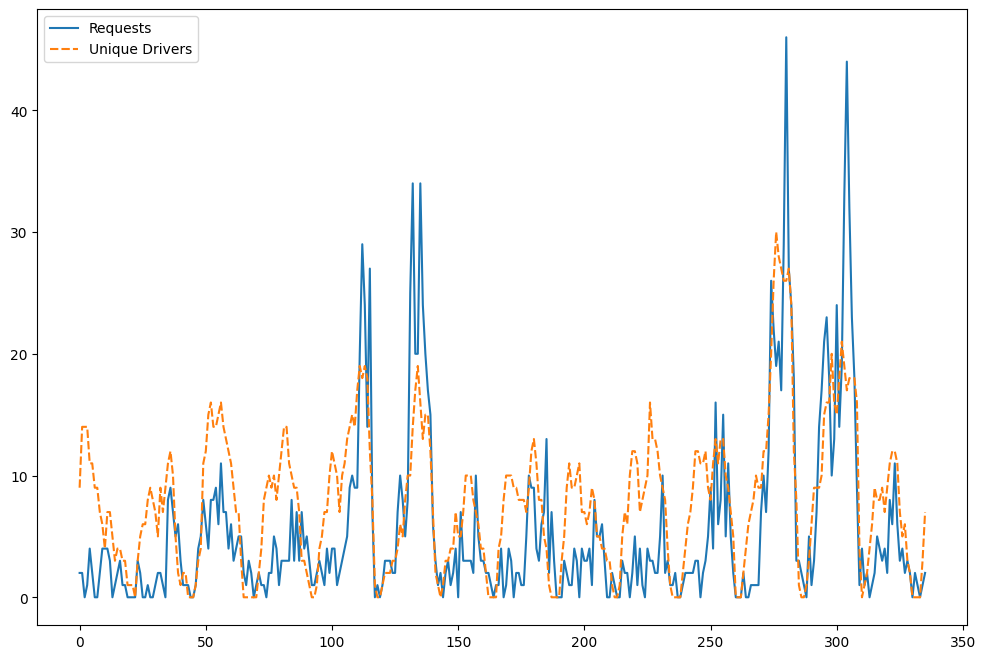

In [23]:

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
sns.lineplot(data=df[['Requests', 'Unique Drivers', 'Timestamp']])
plt.show()

## Question 8 

**In which 72 hour period is the ratio of Zeroes to Eyeballs the
highest?**


In [24]:

# calculate rolling sums by 3 days/ 72 hours 
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=72)
df_agg_three_days = df.set_index("Timestamp").rolling(window=indexer, min_periods=1).sum(numeric_only=True).reset_index()
df_agg_three_days['zeros_to_eyeballs_ratio'] = df_agg_three_days['Zeroes'] / df_agg_three_days['Eyeballs']

In [25]:

df_agg_three_days = df_agg_three_days[df_agg_three_days['Timestamp'] <= (df_agg_three_days['Timestamp'].max() - pd.Timedelta(days=3))]

time_format = "%Y/%m/%d %H:%M"
df_agg_three_days['Time Interval']  = df_agg_three_days['Timestamp'].dt.strftime(time_format) +  "-" + (df_agg_three_days['Timestamp'] + pd.Timedelta('3 days')).dt.strftime(time_format)
df_agg_three_days

,Timestamp,Time (Local),Eyeballs,Zeroes,Completed Trips,Requests,Unique Drivers,Day,completed_trip_ratio_per_driver,Hour,Shift,zeros_to_eyeballs_ratio,Time Interval
0,2012-09-10 07:00:00,828.0,956.0,172.0,159.0,211.0,473.0,93.0,20.807776,0.0,0.0,0.179916,2012/09/10 07:00-2012/09/13 07:00
1,2012-09-10 08:00:00,828.0,961.0,173.0,158.0,210.0,468.0,96.0,20.835553,0.0,0.0,0.180021,2012/09/10 08:00-2012/09/13 08:00
2,2012-09-10 09:00:00,828.0,964.0,174.0,157.0,209.0,462.0,99.0,20.817696,0.0,0.0,0.180498,2012/09/10 09:00-2012/09/13 09:00
3,2012-09-10 10:00:00,828.0,970.0,175.0,157.0,209.0,457.0,102.0,20.817696,0.0,0.0,0.180412,2012/09/10 10:00-2012/09/13 10:00
4,2012-09-10 11:00:00,828.0,976.0,176.0,159.0,210.0,453.0,105.0,21.017696,0.0,0.0,0.180328,2012/09/10 11:00-2012/09/13 11:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,2012-09-21 02:00:00,828.0,2209.0,465.0,535.0,724.0,780.0,352.0,39.191989,0.0,0.0,0.210502,2012/09/21 02:00-2012/09/24 02:00
260,2012-09-21 03:00:00,828.0,2207.0,468.0,534.0,724.0,775.0,348.0,38.991989,0.0,0.0,0.212053,2012/09/21 03:00-2012/09/24 03:00
261,2012-09-21 04:00:00,828.0,2207.0,468.0,534.0,725.0,775.0,344.0,38.991989,0.0,0.0,0.212053,2012/09/21 04:00-2012/09/24 04:00
262,2012-09-21 05:00:00,828.0,2208.0,469.0,534.0,725.0,775.0,340.0,38.991989,0.0,0.0,0.212409,2012/09/21 05:00-2012/09/24 05:00


In [26]:

df_agg_three_days.nlargest(1, 'zeros_to_eyeballs_ratio')['zeros_to_eyeballs_ratio']

118    0.292977
Name: zeros_to_eyeballs_ratio, dtype: float64

In [27]:

df_agg_three_days.nlargest(1, 'zeros_to_eyeballs_ratio')['Time Interval']

118    2012/09/15 05:00-2012/09/18 05:00
Name: Time Interval, dtype: object

## Question 9 

**If you could add 5 drivers to any single hour of every day during the
two week period, which hour should you add them to?**

<Note type="hint">

Consider both rider eyeballs and driver supply when choosing

</Note>

In [28]:

df_agg_time = df.groupby('Time (Local)').sum(numeric_only=True).reset_index()
df_agg_time['eyeball_to_driver_ratio'] = df_agg_time['Eyeballs'] / df_agg_time['Unique Drivers'] 
df_agg_time.nlargest(1, 'eyeball_to_driver_ratio')

,Time (Local),Eyeballs,Zeroes,Completed Trips,Requests,Unique Drivers,Day,completed_trip_ratio_per_driver,Hour,Shift,eyeball_to_driver_ratio
23,23,488,193,126,184,119,42,11.269306,0,0,4.10084


In [29]:

df_agg_time.nlargest(1, 'eyeball_to_driver_ratio')['Time (Local)']

23    23
Name: Time (Local), dtype: int64

## Question 10 

**True or False: There is exactly two weeks of data in this analysis**


In [30]:

# A correct way to check is to count the number of hourly records.
# 14 days × 24 hours = 336 rows means a full 2-week period.

print("Number of rows (hours):", len(df))

if len(df) == 336:
    print("✅ The dataset covers 336 hourly entries, which equals 14 full days.")
    print("Answer: True")
else:
    print("❌ The dataset does not have 336 rows.")
    print("Answer: False")

Number of rows (hours): 336
✅ The dataset covers 336 hourly entries, which equals 14 full days.
Answer: True


## Question 11 

**Looking at the data from all two weeks, which time might make the most
sense to consider a true "end day" instead of midnight? (i.e when are
supply and demand at both their natural minimums)**

<Note type="tip">

Visualize the data to confirm your answer if needed.
</Note>

In [31]:

# find min supply and demand per day
df_min_supply_per_day = df.groupby(['Date'])['Unique Drivers'].min().reset_index().rename(columns={'Unique Drivers':'min_supply_per_day'})
df_min_demand_per_day = df.groupby(['Date'])['Requests'].min().reset_index().rename(columns={'Requests':'min_demand_per_day'})

# merge demand and supply based on date
supply_demand = pd.merge(df_min_supply_per_day, df_min_demand_per_day, on="Date")
supply_demand

,Date,min_supply_per_day,min_demand_per_day
0,10-Sep-12,3,0
1,11-Sep-12,0,0
2,12-Sep-12,0,0
3,13-Sep-12,0,0
4,14-Sep-12,0,1
5,15-Sep-12,0,0
6,16-Sep-12,0,0
7,17-Sep-12,0,0
8,18-Sep-12,0,0
9,19-Sep-12,0,0


In [32]:

# merge found min values with initial dataset on Date
dataset_w_min_supply_demand = pd.merge(df, supply_demand, on="Date")
dataset_w_min_supply_demand

,Date,Time (Local),Eyeballs,Zeroes,Completed Trips,Requests,Unique Drivers,Timestamp,Day,completed_trip_ratio_per_driver,Hour,Shift,min_supply_per_day,min_demand_per_day
0,10-Sep-12,7,5,0,2,2,9,2012-09-10 07:00:00,0,0.222222,0,0,3,0
1,10-Sep-12,8,6,0,2,2,14,2012-09-10 08:00:00,0,0.142857,0,0,3,0
2,10-Sep-12,9,8,3,0,0,14,2012-09-10 09:00:00,0,0.000000,0,0,3,0
3,10-Sep-12,10,9,2,0,1,14,2012-09-10 10:00:00,0,0.000000,0,0,3,0
4,10-Sep-12,11,11,1,4,4,11,2012-09-10 11:00:00,0,0.363636,0,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,24-Sep-12,2,3,3,0,2,0,2012-09-24 02:00:00,0,NaN,0,0,0,0
332,24-Sep-12,3,3,3,0,1,0,2012-09-24 03:00:00,0,NaN,0,0,0,0
333,24-Sep-12,4,1,1,0,0,0,2012-09-24 04:00:00,0,NaN,0,0,0,0
334,24-Sep-12,5,4,2,1,1,3,2012-09-24 05:00:00,0,0.333333,0,0,0,0


In [33]:

# check the exact matches with natural minimums
min_point = dataset_w_min_supply_demand[(dataset_w_min_supply_demand.min_supply_per_day == dataset_w_min_supply_demand['Unique Drivers']) & 
                           (dataset_w_min_supply_demand.min_demand_per_day == dataset_w_min_supply_demand['Requests'])]['Time (Local)'].mode()
min_point

0    4
Name: Time (Local), dtype: int64

In [34]:

# minimum hour is 4 am
min_point[0]

np.int64(4)

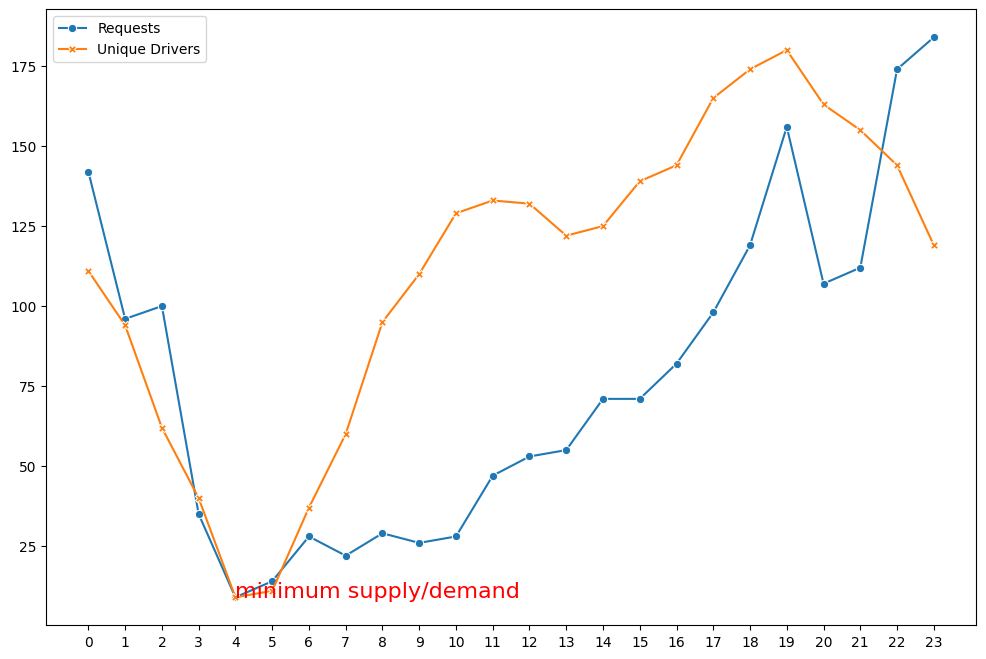

In [35]:

# plot and annotate the minimum hour
df_agg_time = df.groupby('Time (Local)').sum(numeric_only=True).reset_index()
min_point_value = df_agg_time['Requests'][min_point[0]]
plt.figure(figsize=(12,8))
fig = sns.lineplot(data=df_agg_time[['Requests', 'Unique Drivers']], markers=True, dashes=False)
fig.set_xticks(df_agg_time['Time (Local)'])
plt.annotate('minimum supply/demand', xy=(min_point[0], min_point_value), color='r', fontsize=16)
plt.show()